<a href="https://colab.research.google.com/github/K-ssou/App_Profond_Geoguessr/blob/master/Modele_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/K-ssou/App_Profond_Geoguessr.git

Cloning into 'App_Profond_Geoguessr'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 13611 (delta 1), reused 27 (delta 1), pack-reused 13583
Receiving objects: 100% (13611/13611), 2.50 GiB | 54.98 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (6213/6213), done.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [2]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat


def load_data(data_path, classes, dataset='train', image_size=150):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                img = img.convert('RGB')
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

In [18]:
def plot_loss(val_loss, train_loss, ymax=100):
  plt.plot(val_loss, color='green', label='Erreur de validation')
  plt.plot(train_loss, color='blue', linestyle='--', label='Erreur d\'entraînement')
  plt.xlabel('Epochs')
  plt.ylim(0, ymax)
  plt.title('Évolution de la perte sur les ensembles d\'apprentissage et de validation au cours de l\'apprentissage')
  plt.legend()

In [82]:
def plot_training_analysis():
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [45]:

labels = ['Dubai', 'LeCaire', 'Moscou', 'NewYork', 'Paris', 'Tokyo']

x_train, y_train = load_data('./App_Profond_Geoguessr/Images/', labels, dataset='train', image_size=150)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data('./App_Profond_Geoguessr/Images/', labels, dataset='validation', image_size=150)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data('./App_Profond_Geoguessr/Images/', labels, dataset='test', image_size=150)
print(x_test.shape, y_test.shape)


(4371, 150, 150, 3) (4371, 1)
(1211, 150, 150, 3) (1211, 1)
(625, 150, 150, 3) (625, 1)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

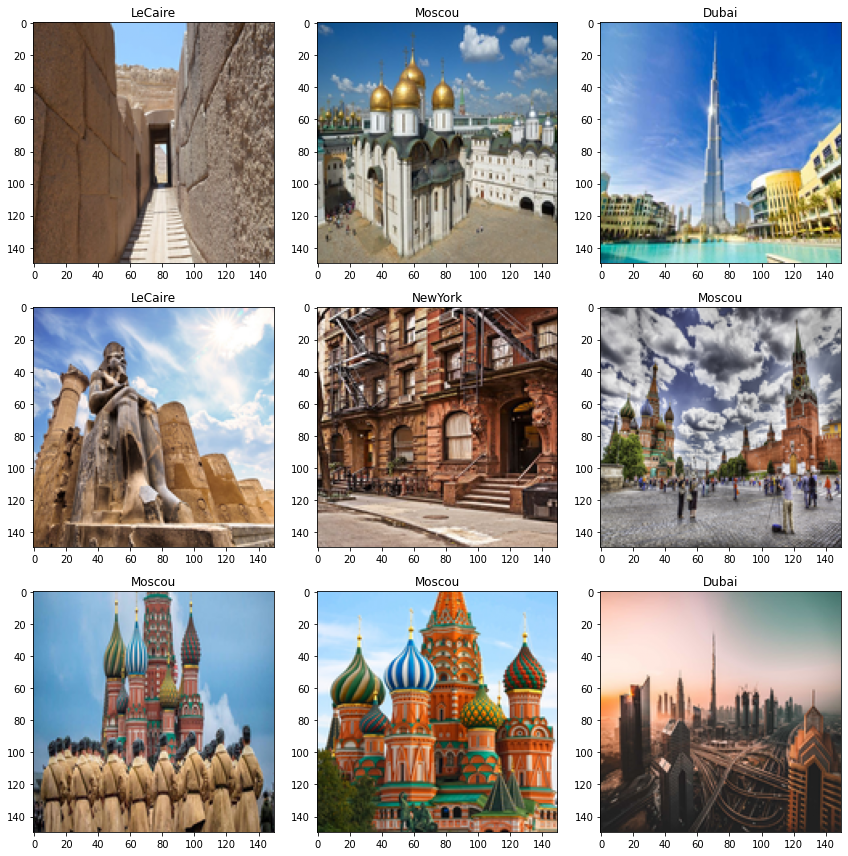

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(2500)
shuffle_indices = shuffle_indices
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

In [48]:
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [75]:
model = models.Sequential()
model.add(Conv2D(32,(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(6, activation='softmax'))   # Couche de sortie

In [76]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 128)      

In [77]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

In [78]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=100)

Epoch 1/50
44/44 [==============================] - 3s 49ms/step - loss: 18.5147 - acc: 0.2539 - val_loss: 1.1340 - val_acc: 0.5995
Epoch 2/50
44/44 [==============================] - 2s 44ms/step - loss: 0.9579 - acc: 0.6552 - val_loss: 0.7814 - val_acc: 0.7316
Epoch 3/50
44/44 [==============================] - 2s 44ms/step - loss: 0.6617 - acc: 0.7652 - val_loss: 0.7426 - val_acc: 0.7407
Epoch 4/50
44/44 [==============================] - 2s 44ms/step - loss: 0.5457 - acc: 0.8128 - val_loss: 0.6966 - val_acc: 0.7663
Epoch 5/50
44/44 [==============================] - 2s 44ms/step - loss: 0.3888 - acc: 0.8648 - val_loss: 0.7267 - val_acc: 0.7539
Epoch 6/50
44/44 [==============================] - 2s 45ms/step - loss: 0.2932 - acc: 0.9053 - val_loss: 0.8083 - val_acc: 0.7300
Epoch 7/50
44/44 [==============================] - 2s 44ms/step - loss: 0.2705 - acc: 0.9117 - val_loss: 0.6939 - val_acc: 0.7663
Epoch 8/50
44/44 [==============================] - 2s 43ms/step - loss: 0.1433 - 

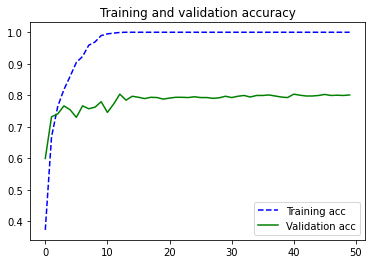

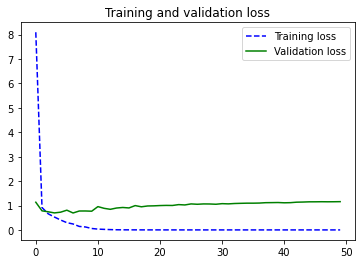

In [84]:

plot_training_analysis()